In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

--- Building Scenario 1: Uniform ---
Scenario 'Scenario_Uniform' created with UUID: 0694991b-ff61-7b7e-8000-af682f9b8adf
Directory: demo_output/Scenario_Uniform


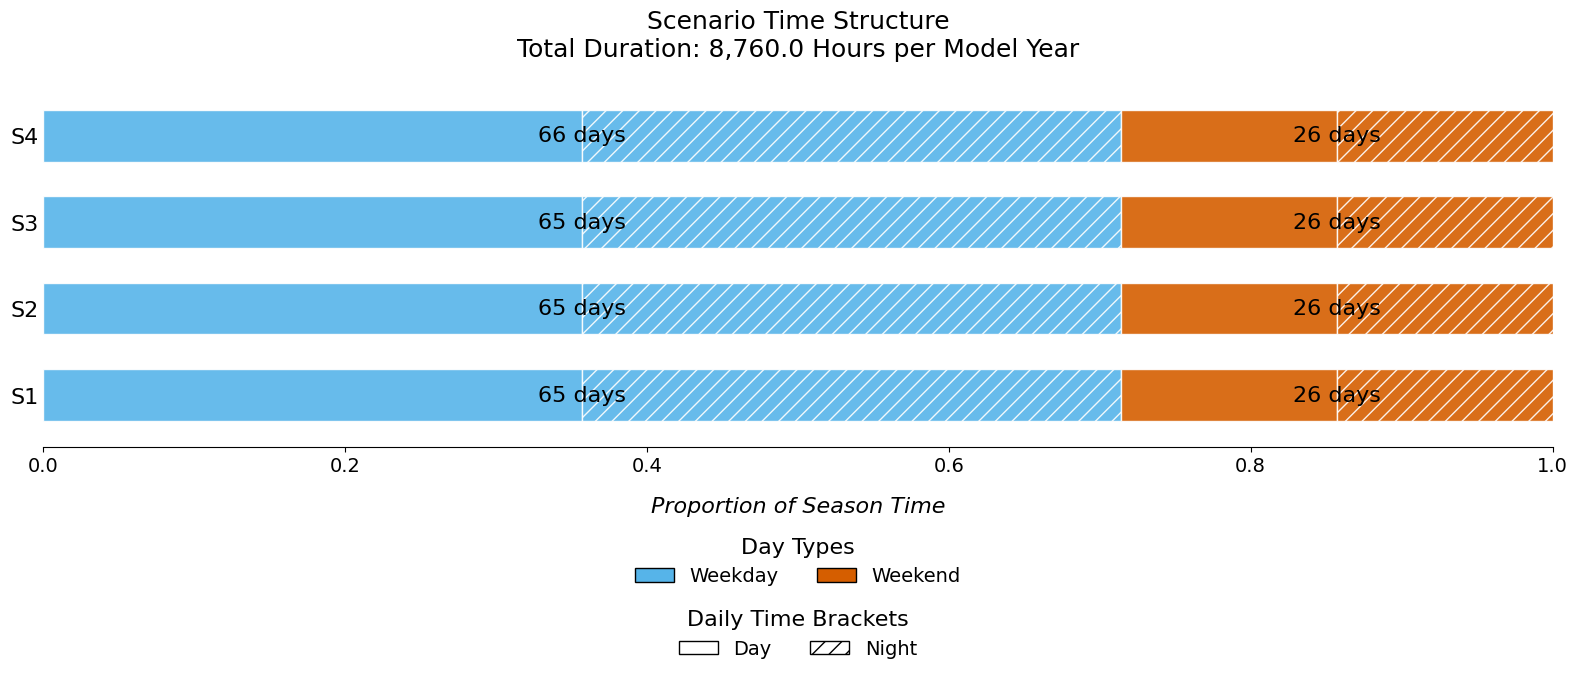


--- Building Scenario 2: Complex ---
Scenario 'Scenario_Complex' created with UUID: 0694991c-0537-75b8-8000-637f48a4ee7b
Directory: demo_output/Scenario_Complex
Scenario 2 generated at: demo_output/Scenario_Complex


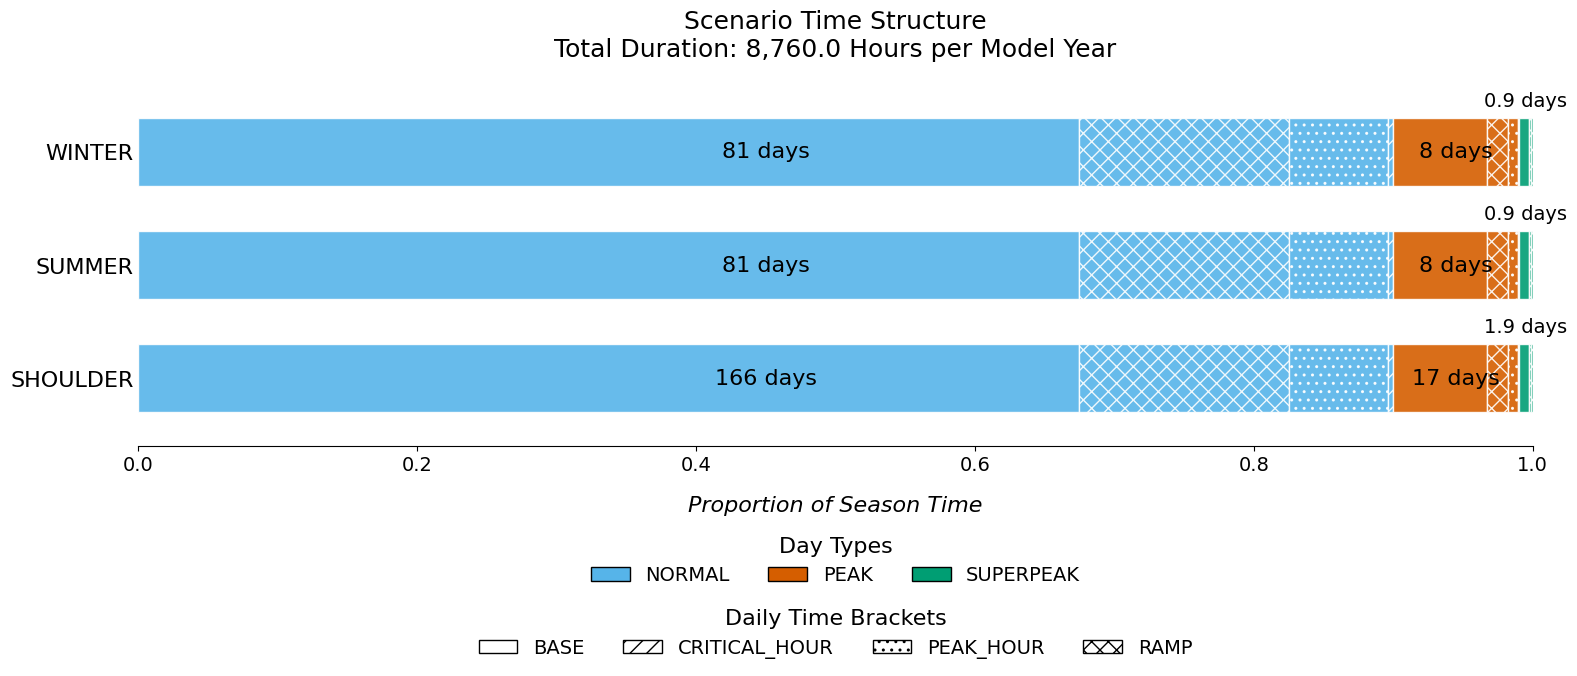

In [ ]:
import shutil
import yaml
import csv
from pyoscomp.scenario.manager import ScenarioManager

# --- Helper to clean up previous runs for this demo ---
WORK_DIR = "demo_output"
if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)
os.makedirs(WORK_DIR)

# Create a minimal config file for the demo
config_content = """
REGION:
  type: set
YEAR:
  type: set
SEASON:
  type: set
DAYTYPE:
  type: set
DAILYTIMEBRACKET:
  type: set
TIMESLICE:
  type: set
YearSplit:
  type: param
  columns: ["TIMESLICE", "YEAR", "VALUE"]
DaySplit:
  type: param
  columns: ["DAILYTIMEBRACKET", "YEAR", "VALUE"]
DaysInDayType:
  type: param
  columns: ["SEASON", "DAYTYPE", "YEAR", "VALUE"]
"""

config_path = os.path.join(WORK_DIR, "osemosys_config.yaml")
with open(config_path, "w") as f:
    f.write(config_content)

# ==========================================
# SCENARIO 1: Simple / Uniform
# ==========================================
print("--- Building Scenario 1: Uniform ---")
manager_1 = ScenarioManager(
    tag="Scenario_Uniform", 
    parent_dir=WORK_DIR,
    # config_path=config_path,
    master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
)
s1 = manager_1.create_scenario()

s1.set_topology_structure(nodes=5) # 5 generic nodes
s1.set_time_structure(
    years=(2020, 2030, 1), # annual steps
    seasons={"S1": 91, "S2": 91, "S3": 91, "S4": 92}, # 4 near-equal length seasons
    daytypes={"Weekday": 5, "Weekend": 2}, # 5 weekdays, 2 weekend days
    brackets={"Day": 12, "Night": 12} # 12 hours day, 12 hours night
)
s1.time.visualize()

# ==========================================
# SCENARIO 2: Maximum Complexity (Cartesian)
# ==========================================
print("\n--- Building Scenario 2: Complex ---")
manager_2 = ScenarioManager(
    tag="Scenario_Complex", 
    parent_dir=WORK_DIR,
    config_path=config_path,
    master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
)
s2 = manager_2.create_scenario()
s2.set_topology_structure(nodes=["Grid_North", "Grid_South"]) # 2 specific nodes

# 1. SEASONS: Irregular lengths
seasons_conf = {
    "WINTER": 90,
    "SUMMER": 90,
    "SHOULDER": 185
}

# 2. DAY TYPES: 
# We include a "SuperPeak" day (e.g. 1-in-10 year cold snap).
# Even though it's rare, it gets its own DayType.
daytypes_conf = {
    "NORMAL": 0.90,    # Most days
    "PEAK": 0.09,      # High demand days
    "SUPERPEAK": 0.01  # Extreme anomaly (approx 3.6 days/year)
}

# 3. BRACKETS: 
# We include a "Critical Hour" (e.g., 6pm-7pm).
# Cartesian Note: This bracket will generate for ALL day types.
# - SUPERPEAK_CRITICAL_HOUR (The most dangerous hour of the year)
# - NORMAL_CRITICAL_HOUR (Just 6pm on a Tuesday)
brackets_conf = {
    "BASE": 18,            # Bulk of the day
    "RAMP": 4,             # Morning/Evening ramps
    "PEAK_HOUR": 1.9,      # Standard peak window
    "CRITICAL_HOUR": 0.1   # Super sharp spike (let's say 0.1 fraction of day = 2.4 hours)
}

# Process
s2.set_time_structure(
    years = (2025, 2030, 5),
    seasons=seasons_conf,
    daytypes=daytypes_conf,
    brackets=brackets_conf
)

print(f"Scenario 2 generated at: {s2.scenario_dir}")
s2.time.visualize()

In [3]:
print(s1.node_list)
print(s1.time_list)
print(s1.time_hours) # all time steps in whole hours

['Node_1', 'Node_2', 'Node_3', 'Node_4', 'Node_5']
[(2020, 'S1_Weekday_Day'), (2020, 'S1_Weekday_Night'), (2020, 'S1_Weekend_Day'), (2020, 'S1_Weekend_Night'), (2020, 'S2_Weekday_Day'), (2020, 'S2_Weekday_Night'), (2020, 'S2_Weekend_Day'), (2020, 'S2_Weekend_Night'), (2020, 'S3_Weekday_Day'), (2020, 'S3_Weekday_Night'), (2020, 'S3_Weekend_Day'), (2020, 'S3_Weekend_Night'), (2020, 'S4_Weekday_Day'), (2020, 'S4_Weekday_Night'), (2020, 'S4_Weekend_Day'), (2020, 'S4_Weekend_Night'), (2021, 'S1_Weekday_Day'), (2021, 'S1_Weekday_Night'), (2021, 'S1_Weekend_Day'), (2021, 'S1_Weekend_Night'), (2021, 'S2_Weekday_Day'), (2021, 'S2_Weekday_Night'), (2021, 'S2_Weekend_Day'), (2021, 'S2_Weekend_Night'), (2021, 'S3_Weekday_Day'), (2021, 'S3_Weekday_Night'), (2021, 'S3_Weekend_Day'), (2021, 'S3_Weekend_Night'), (2021, 'S4_Weekday_Day'), (2021, 'S4_Weekday_Night'), (2021, 'S4_Weekend_Day'), (2021, 'S4_Weekend_Night'), (2022, 'S1_Weekday_Day'), (2022, 'S1_Weekday_Night'), (2022, 'S1_Weekend_Day'), (202

In [4]:
print(s2.node_list)
print(s2.time_list)
print(s2.time_hours) # non-uniform time steps as small as 0.09 hours

['Grid_North', 'Grid_South']
[(2025, 'WINTER_NORMAL_BASE'), (2025, 'WINTER_NORMAL_RAMP'), (2025, 'WINTER_NORMAL_PEAK_HOUR'), (2025, 'WINTER_NORMAL_CRITICAL_HOUR'), (2025, 'WINTER_PEAK_BASE'), (2025, 'WINTER_PEAK_RAMP'), (2025, 'WINTER_PEAK_PEAK_HOUR'), (2025, 'WINTER_PEAK_CRITICAL_HOUR'), (2025, 'WINTER_SUPERPEAK_BASE'), (2025, 'WINTER_SUPERPEAK_RAMP'), (2025, 'WINTER_SUPERPEAK_PEAK_HOUR'), (2025, 'WINTER_SUPERPEAK_CRITICAL_HOUR'), (2025, 'SUMMER_NORMAL_BASE'), (2025, 'SUMMER_NORMAL_RAMP'), (2025, 'SUMMER_NORMAL_PEAK_HOUR'), (2025, 'SUMMER_NORMAL_CRITICAL_HOUR'), (2025, 'SUMMER_PEAK_BASE'), (2025, 'SUMMER_PEAK_RAMP'), (2025, 'SUMMER_PEAK_PEAK_HOUR'), (2025, 'SUMMER_PEAK_CRITICAL_HOUR'), (2025, 'SUMMER_SUPERPEAK_BASE'), (2025, 'SUMMER_SUPERPEAK_RAMP'), (2025, 'SUMMER_SUPERPEAK_PEAK_HOUR'), (2025, 'SUMMER_SUPERPEAK_CRITICAL_HOUR'), (2025, 'SHOULDER_NORMAL_BASE'), (2025, 'SHOULDER_NORMAL_RAMP'), (2025, 'SHOULDER_NORMAL_PEAK_HOUR'), (2025, 'SHOULDER_NORMAL_CRITICAL_HOUR'), (2025, 'SHOULDER

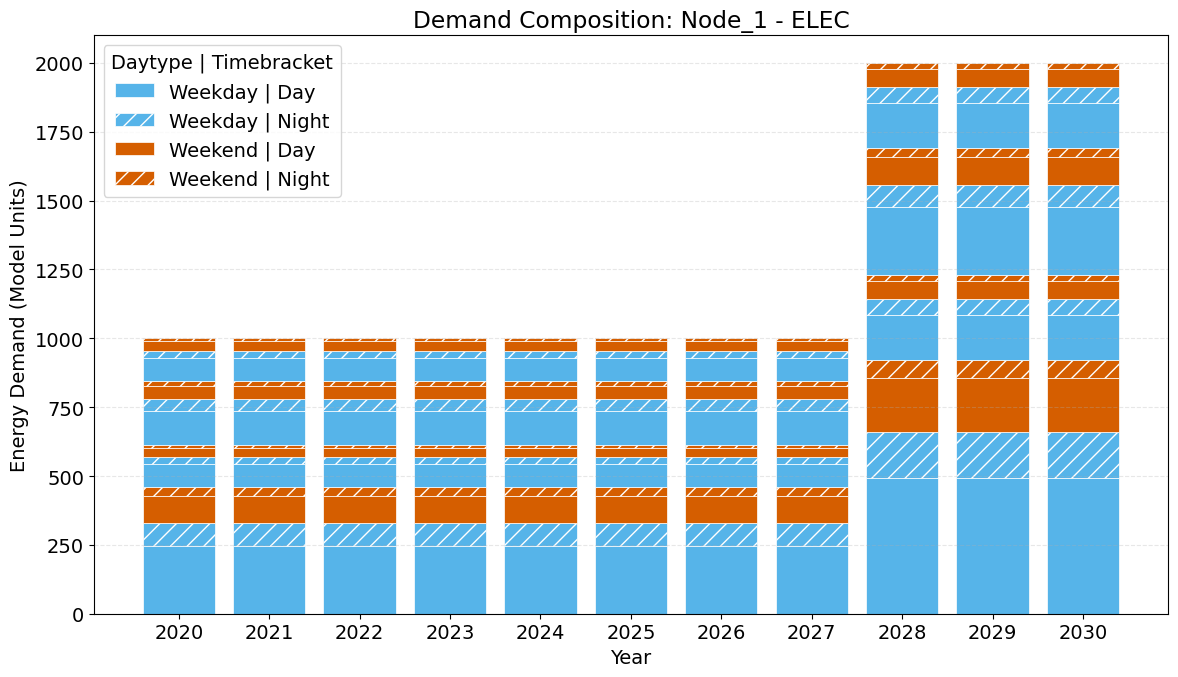

In [5]:
s1.set_interyear_demand("Node_1", "ELEC", trajectory={2020: 1000, 2028: 2000}, interpolation="step")
s1.set_intrayear_demand("Node_1", "ELEC",
    weights_seasons={"S1": 3.0, "S2": 1.0, "S3": 1.5, "S4": 1.0},
    weights_brackets={"Day": 1.5, "Night": 0.5})
s1.demand.visualize("Node_1", "ELEC")


--- Listing All Scenarios ---
Found 2 scenarios:
  - Scenario_Uniform (0694991b-ff61-7b7e-8000-af682f9b8adf)
  - Scenario_Complex (0694991c-0537-75b8-8000-637f48a4ee7b)

--- Loading Scenario by UUID ---
Loaded scenario 'Scenario_Complex' with UUID: 0694991c-0537-75b8-8000-637f48a4ee7b
Directory: demo_output/Scenario_Complex
Successfully loaded: Scenario_Complex


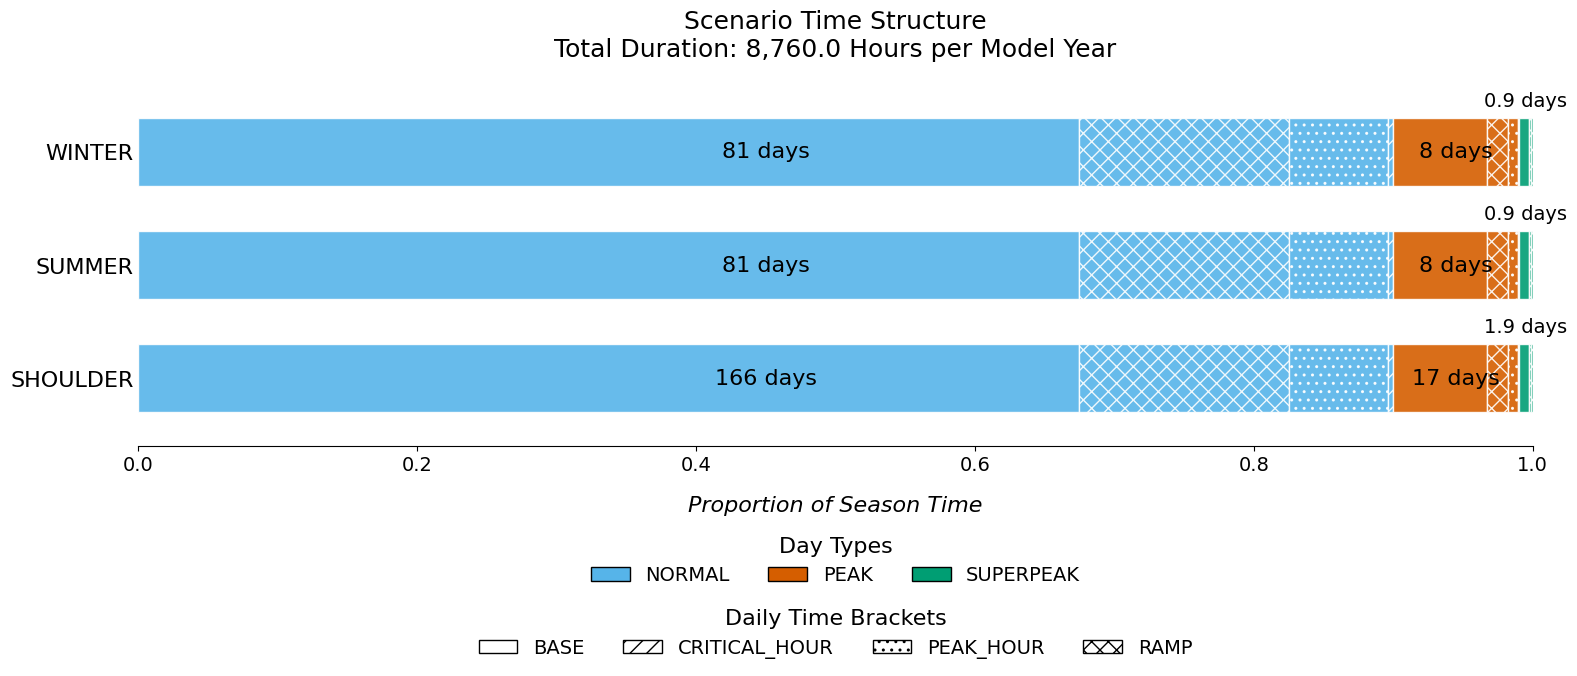

In [7]:
# ==========================================
# LIST AND LOAD DEMONSTRATION
# ==========================================
print("\n--- Listing All Scenarios ---")
# Create a manager without a tag to list scenarios
list_manager = ScenarioManager(
    parent_dir=WORK_DIR,
    config_path=config_path,
    master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
)

scenarios = list_manager.list_scenarios()
print(f"Found {len(scenarios)} scenarios:")
for scenario in scenarios:
    print(f"  - {scenario['tag']} ({scenario['uuid']})")

# ==========================================
# LOAD A SCENARIO BY UUID
# ==========================================
print("\n--- Loading Scenario by UUID ---")
if scenarios:
    sample_uuid = scenarios[-1]["uuid"]
    loaded_manager = ScenarioManager.from_uuid(
        uuid=sample_uuid,
        parent_dir=WORK_DIR,
        config_path=config_path,
        master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
    )
    
    scenario = loaded_manager.load_scenario()
    print(f"Successfully loaded: {loaded_manager.tag}")
    scenario.time.visualize()